## accountMetrics - Measuring Site Throughput, Part 2

[Part 1](accountMetrics%20-%20Measuring%20Site%20Throughput%2C%20Part%201.ipynb) showed how to use the [accountMetrics](https://api.catonetworks.com/documentation/#query-accountMetrics) query to generate throughput graphs similar to the ones displayed in CMA.

This example requires the Matplotlib third party package.

These are the CMA graphs we will combine into a single Matplotlib graph.

![goal2.png](goal2.png)

Firstly, let's import the libraries we need and set up the connection to the API. As usual, we assuming that the account ID and API key are preloaded as environment variables and we use our helper module to encapsulate the business of making an API call (see the [Getting Started](Getting%20Started.ipynb) notebook if any of this is unclear):

In [1]:
#
# Initialise the API connection
#
import datetime
import json
import os
import matplotlib.pyplot as plt
from cato import API
C = API(os.environ["CATO_API_KEY"])

## The accountMetrics query

For this example we are going to add the **bytesUpstreamMax** timeseries to the [accountMetrics](https://api.catonetworks.com/documentation/#query-accountMetrics) query, so we can see both up and down traffic in the same graph.

In [2]:
#
# Define the query
#
query = '''
query accountMetrics($buckets:Int $accountID:ID! $timeFrame:TimeFrame! $siteIDs:[ID!]) {
    accountMetrics(accountID:$accountID timeFrame:$timeFrame groupInterfaces:false groupDevices:true) {
        sites (siteIDs:$siteIDs) {
            id
            name
            interfaces {
                name
                timeseries (labels:[bytesDownstreamMax, bytesUpstreamMax] buckets:$buckets) {
                    label
                    units
                    data (perSecond:true)
                }
            }
        }
    }
}
'''


#
# Variables
#
variables = {
    "accountID": os.environ["CATO_ACCOUNT_ID"],
    "timeFrame": "utc.2025-02-09/{00:00:00--23:59:59}",
    "buckets": 288,
    "siteIDs": [119167],
}

## Sending the query

Now we send the query, which should now return two timeseries':

In [3]:
#
# Send the query
#
success, result = C.send("accountMetrics", variables, query)
print(len(result["data"]["accountMetrics"]["sites"][0]["interfaces"][0]["timeseries"]))

2


## Process the response

Having multiple timeseries in the response means that we need to identify each timeseries from the label.

In [4]:
#
# Construct the X and Y timeseries
#
#
y_up = []
y_down = []
x_up = []
x_down = []
for timeseries in result["data"]["accountMetrics"]["sites"][0]["interfaces"][0]["timeseries"]:
    for timestamp, value in timeseries["data"]:
    
        #
        # Convert the timestamp to a Python datetime and add to x
        #
        datetime_timestamp = datetime.datetime.fromtimestamp(timestamp/1000)
    
        #
        # Convert the value to megabits per second and add to x
        #
        bps = value*8/1_000_000
        if timeseries["label"] == "bytesDownstreamMax":
            x_down.append(datetime_timestamp)
            y_down.append(bps)
        elif timeseries["label"] == "bytesUpstreamMax":
            x_up.append(datetime_timestamp)
            y_up.append(bps)

#
# We assume that the up labels will also suffice for down
#
x_labels = [X.strftime("%H:%M") for X in x_up]

## Create the graph

We plot the up values in green, and the down values in blue:

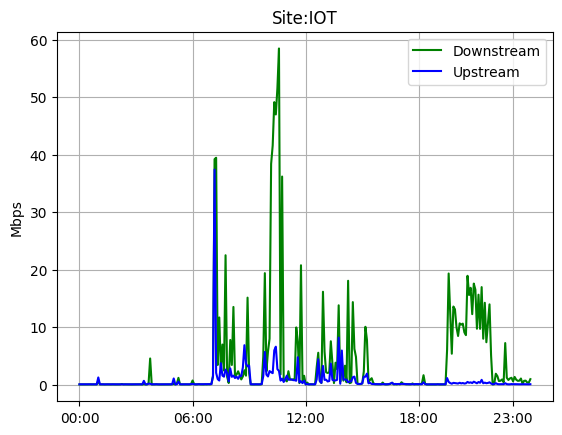

In [5]:
#
# We only want several specific X-labels
#
xtick_locs = []
xtick_labels = []
for i,label in zip(x_up, x_labels):
    if label in ["00:00", "06:00", "12:00", "18:00", "23:00"]:
        xtick_locs.append(i)
        xtick_labels.append(label)

#
# Create and show the graph
#
plt.close("all")
plt.title(f"Site:{result["data"]["accountMetrics"]["sites"][0]["name"]}")
plt.ylabel(f"Mbps")
plt.xticks(xtick_locs, xtick_labels)
plt.grid()
plt.plot(x_down, y_down, label="Downstream", color="green")
plt.plot(x_up, y_up, label="Upstream", color="blue")
plt.legend()
plt.show()
